In [1]:
import sqlite3
import pandas as pd

# Connect to the SQLite database
db_path = "../youbike_data.db"
conn = sqlite3.connect(db_path)

# Query for YouBike status data
youbike_query = """
SELECT 
    sno AS youbike_station_id,
    mday AS timestamp,
    available_rent_bikes,
    available_return_bikes
FROM youbike_status
"""

# Query for weather data
weather_query = """
SELECT 
    station_name AS weather_station_name,
    observe_time AS timestamp,
    temperature,
    weather,
    wind_speed,
    humidity,
    pressure,
    rainfall
FROM weather
"""

# Load the data into separate DataFrames
df_youbike = pd.read_sql_query(youbike_query, conn)
df_weather = pd.read_sql_query(weather_query, conn)

df_youbike['capacity'] = df_youbike['available_rent_bikes'] + df_youbike['available_return_bikes']

# Close the connection
conn.close()

# Display shapes for sanity check
print(f"YouBike Data Shape: {df_youbike.shape}")
print(f"Weather Data Shape: {df_weather.shape}")


YouBike Data Shape: (10114051, 5)
Weather Data Shape: (17042, 8)


In [2]:
# df_weather.iloc[970]
df_weather.head(971)

,weather_station_name,timestamp,temperature,weather,wind_speed,humidity,pressure,rainfall
0,Anpu,20:00,10.3,CLOUDY WITH RAIN,2.0,100.0,NaN,16.0
1,Taipei,20:00,15.6,CLOUDY WITH RAIN,2.0,93.0,1023.0,7.5
2,Yangmingshan,20:00,11.7,CLOUDY,3.0,98.0,1023.5,11.5
3,NTU,20:00,15.4,CLOUDY WITH RAIN,0.0,91.0,NaN,8.5
4,PCCU,20:00,13.3,CLOUDY,3.0,90.0,NaN,5.6
...,...,...,...,...,...,...,...,...
966,Freeway No. 3 - CCTV – S016K,None,NaN,None,NaN,NaN,NaN,NaN
967,Freeway No. 3 - CCTV – A005K,None,NaN,None,NaN,NaN,NaN,NaN
968,Da'an Forest Park,11:10,17.1,CLOUDY,1.0,86.0,NaN,4.5
969,Agriculture Guandu Station,11:10,18.6,CLOUDY,3.0,67.0,NaN,4.0


In [3]:
df_weather_filtered = df_weather.loc[970:].reset_index(drop=True)


In [4]:
df_weather_filtered.head()

,weather_station_name,timestamp,temperature,weather,wind_speed,humidity,pressure,rainfall
0,Anpu,2024-12-24 11:57:18,10.9,CLOUDY WITH RAIN,2.0,100.0,NaN,25.0
1,Taipei,2024-12-24 11:57:18,17.1,CLOUDY,3.0,86.0,1023.5,5.5
2,Yangmingshan,2024-12-24 11:57:18,12.7,CLOUDY,3.0,98.0,1023.8,18.5
3,NTU,2024-12-24 11:57:18,17.4,CLOUDY,2.0,81.0,NaN,6.0
4,PCCU,2024-12-24 11:57:18,NaN,CLOUDY,NaN,NaN,NaN,NaN


In [5]:
df_youbike

,youbike_station_id,timestamp,available_rent_bikes,available_return_bikes,capacity
0,500101001,2024-12-19 16:39:15,27,1,28
1,500101002,2024-12-19 16:40:16,14,7,21
2,500101003,2024-12-19 16:34:16,11,5,16
3,500101004,2024-12-19 16:38:15,10,1,11
4,500101005,2024-12-19 16:39:15,1,15,16
...,...,...,...,...,...
10114046,500119064,2024-12-30 18:08:16,1,27,28
10114047,500119066,2024-12-30 18:08:16,7,12,19
10114048,500119067,2024-12-30 18:08:16,0,42,42
10114049,500119085,2024-12-30 18:08:16,1,13,14


In [6]:
earliest_weather_timestamp = pd.to_datetime(df_weather_filtered["timestamp"]).min()

In [7]:
# Filter the YouBike DataFrame to start from the earliest weather timestamp
df_youbike_filtered = df_youbike[
    pd.to_datetime(df_youbike["timestamp"]) >= earliest_weather_timestamp
].reset_index(drop=True)

# Display the filtered DataFrame
print(df_youbike_filtered)

        youbike_station_id            timestamp  available_rent_bikes  \
0                500101001  2024-12-24 11:58:17                     3   
1                500101002  2024-12-24 11:58:16                    15   
2                500101003  2024-12-24 11:58:15                     0   
3                500101005  2024-12-24 11:58:16                    15   
4                500101007  2024-12-24 11:58:17                     5   
...                    ...                  ...                   ...   
1850014          500119064  2024-12-30 18:08:16                     1   
1850015          500119066  2024-12-30 18:08:16                     7   
1850016          500119067  2024-12-30 18:08:16                     0   
1850017          500119085  2024-12-30 18:08:16                     1   
1850018          500119094  2024-12-30 18:08:16                    39   

         available_return_bikes  capacity  
0                            24        27  
1                             6    

In [8]:
# Ensure the data is sorted by station_id and timestamp for proper calculations
df_youbike_filtered = df_youbike_filtered.sort_values(by=["youbike_station_id", "timestamp"])

# Compute the demand column as the negative difference in available_rent_bikes per station
df_youbike_filtered["demand"] = df_youbike_filtered.groupby("youbike_station_id")["available_rent_bikes"].diff(periods=-1)

# Replace NaN values (e.g., from the last entry of each group) with 0, as there's no further difference to calculate
df_youbike_filtered["demand"] = df_youbike_filtered["demand"].fillna(method="ffill").fillna(method="bfill")

# Convert demand to integer if necessary
df_youbike_filtered["demand"] = df_youbike_filtered["demand"].astype(int)

# Display the updated DataFrame
print(df_youbike_filtered.head())


     youbike_station_id            timestamp  available_rent_bikes  \
0             500101001  2024-12-24 11:58:17                     3   
274           500101001  2024-12-24 11:59:16                     4   
797           500101001  2024-12-24 12:01:17                     3   
1073          500101001  2024-12-24 12:02:17                     4   
1341          500101001  2024-12-24 12:03:16                     5   

      available_return_bikes  capacity  demand  
0                         24        27      -1  
274                       23        27       1  
797                       24        27      -1  
1073                      23        27      -1  
1341                      22        27      -2  


/tmp/ipykernel_1668579/209070775.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_youbike_filtered["demand"] = df_youbike_filtered["demand"].fillna(method="ffill").fillna(method="bfill")


In [9]:
# # let's create a demand forecast for one single station: Main Gate NTUST
# df_NTUST = df_youbike_filtered[df_youbike_filtered["sno"] == '500101024']
# # Set timestamp as index
# df_NTUST.set_index("timestamp", inplace=True)
# # Calculate demand as the difference in available_rent_bikes
# df_NTUST["demand"] = df_NTUST["available_rent_bikes"].diff()


In [10]:
df_youbike_filtered

,youbike_station_id,timestamp,available_rent_bikes,available_return_bikes,capacity,demand
0,500101001,2024-12-24 11:58:17,3,24,27,-1
274,500101001,2024-12-24 11:59:16,4,23,27,1
797,500101001,2024-12-24 12:01:17,3,24,27,-1
1073,500101001,2024-12-24 12:02:17,4,23,27,-1
1341,500101001,2024-12-24 12:03:16,5,22,27,-2
...,...,...,...,...,...,...
1820723,500119096,2024-12-30 17:06:16,33,66,99,1
1821211,500119096,2024-12-30 17:07:15,32,67,99,2
1826325,500119096,2024-12-30 17:18:17,30,69,99,-1
1830436,500119096,2024-12-30 17:27:15,31,68,99,1


In [11]:
# Define a helper function to adjust values
def adjust_to_capacity(row):
    row["available_return_bikes"] = row["capacity"] - int(row["available_rent_bikes"])
    row["available_rent_bikes"] = int(row["available_rent_bikes"])
    return row


In [12]:
import pandas as pd

# Ensure the 'timestamp' column in both DataFrames is datetime and non-null
df_youbike_filtered['timestamp'] = pd.to_datetime(df_youbike_filtered['timestamp'])
df_weather['timestamp'] = pd.to_datetime(df_weather['timestamp'], errors='coerce')

# Drop rows with null timestamps in weather DataFrame
df_weather.dropna(subset=["timestamp"], inplace=True)

# Reset index to avoid ambiguity with groupby
df_youbike_filtered.reset_index(inplace=True, drop=True)

# Ensure only numeric columns are included in the resample
numeric_columns = df_youbike_filtered.select_dtypes(include=['number']).columns.tolist()

# Fill missing values in YouBike data grouped by station
df_youbike_filtered = (
    df_youbike_filtered
    .groupby("youbike_station_id", group_keys=False)
    .apply(lambda group: group.ffill().bfill())
    .reset_index(drop=True)
)

# Resample YouBike data to 10-minute intervals and compute averages
df_youbike_resampled = (
    df_youbike_filtered
    .set_index("timestamp")
    .groupby("youbike_station_id")[numeric_columns]
    .resample("10min")
    .mean()
    .fillna(method="ffill")
    .fillna(method="bfill")
    .reset_index()
)

df_youbike_resampled = df_youbike_resampled.apply(adjust_to_capacity, axis=1)


# Resample weather data to 10-minute intervals using forward and backward fill
df_weather_resampled = (
    df_weather
    .set_index("timestamp")
    .resample("10min")
    .mean(numeric_only=True)  # Ensure only numeric columns are included
    .fillna(method="ffill")
    .fillna(method="bfill")
    .reset_index()
)

# Ensure both DataFrames are sorted by 'timestamp'
df_youbike_resampled.sort_values("timestamp", inplace=True)
df_weather_resampled.sort_values("timestamp", inplace=True)

# Perform an asof join to match YouBike data with the nearest weather data
df_merged = pd.merge_asof(
    df_youbike_resampled,
    df_weather_resampled,
    left_on="timestamp",
    right_on="timestamp",
    direction="backward",  # Use the most recent weather data point up to the YouBike timestamp
    tolerance=pd.Timedelta("10min"),  # Match only within a 10-minute window
)

# Drop rows where no weather data was found within the tolerance
df_merged.dropna(subset=["temperature"], inplace=True)

# Reset the index for the merged DataFrame
df_merged.reset_index(drop=True, inplace=True)

# Display the resulting DataFrame
print(df_merged.head())


/tmp/ipykernel_1668579/472626770.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_weather['timestamp'] = pd.to_datetime(df_weather['timestamp'], errors='coerce')
/tmp/ipykernel_1668579/472626770.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.ffill().bfill())
/tmp/ipykernel_1668579/472626770.py:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_youbike_filtered
/tmp/ipykernel_1668579/472626770.py:41: FutureWarning: DataFrame.fill

  youbike_station_id           timestamp  available_rent_bikes  \
0          500101001 2024-12-24 11:50:00                     3   
1          500106025 2024-12-24 11:50:00                     2   
2          500106023 2024-12-24 11:50:00                    18   
3          500112032 2024-12-24 11:50:00                     9   
4          500106021 2024-12-24 11:50:00                    30   

   available_return_bikes  capacity  demand  temperature  wind_speed  \
0                    24.0      27.0     0.0        16.14    2.266667   
1                    39.0      41.0    -1.0        16.14    2.266667   
2                     2.0      20.0     1.0        16.14    2.266667   
3                    45.0      54.0     0.0        16.14    2.266667   
4                     4.0      34.0    -1.0        16.14    2.266667   

    humidity  pressure  rainfall  
0  85.642857   1023.65       7.5  
1  85.642857   1023.65       7.5  
2  85.642857   1023.65       7.5  
3  85.642857   1023.65       7

In [13]:
df_merged

,youbike_station_id,timestamp,available_rent_bikes,available_return_bikes,capacity,demand,temperature,wind_speed,humidity,pressure,rainfall
0,500101001,2024-12-24 11:50:00,3,24.0,27.0,0.000000,16.140000,2.266667,85.642857,1023.65,7.5
1,500106025,2024-12-24 11:50:00,2,39.0,41.0,-1.000000,16.140000,2.266667,85.642857,1023.65,7.5
2,500106023,2024-12-24 11:50:00,18,2.0,20.0,1.000000,16.140000,2.266667,85.642857,1023.65,7.5
3,500112032,2024-12-24 11:50:00,9,45.0,54.0,0.000000,16.140000,2.266667,85.642857,1023.65,7.5
4,500106021,2024-12-24 11:50:00,30,4.0,34.0,-1.000000,16.140000,2.266667,85.642857,1023.65,7.5
...,...,...,...,...,...,...,...,...,...,...,...
1341099,500119095,2024-12-30 18:00:00,0,33.0,33.0,0.333333,16.072222,1.055556,79.277778,1021.40,0.0
1341100,500106104,2024-12-30 18:00:00,16,3.0,19.0,-0.333333,16.072222,1.055556,79.277778,1021.40,0.0
1341101,500101161,2024-12-30 18:00:00,8,10.0,18.0,0.666667,16.072222,1.055556,79.277778,1021.40,0.0
1341102,500108122,2024-12-30 18:00:00,1,19.0,20.0,0.666667,16.072222,1.055556,79.277778,1021.40,0.0


In [14]:
print(df_youbike_filtered.isna().sum())

youbike_station_id        0
timestamp                 0
available_rent_bikes      0
available_return_bikes    0
capacity                  0
demand                    0
dtype: int64


In [15]:
# Check for NaN values in the resulting DataFrame
print(df_merged.isna().sum())

youbike_station_id        0
timestamp                 0
available_rent_bikes      0
available_return_bikes    0
capacity                  0
demand                    0
temperature               0
wind_speed                0
humidity                  0
pressure                  0
rainfall                  0
dtype: int64


In [16]:
# Check resampled data for correctness
print(df_youbike_resampled.head())

# Verify that resampled intervals are consistent
print(df_youbike_resampled["timestamp"].diff().value_counts())  # Should all be 10-minute intervals


        youbike_station_id           timestamp  available_rent_bikes  \
0                500101001 2024-12-24 11:50:00                     3   
452741           500106025 2024-12-24 11:50:00                     2   
451839           500106023 2024-12-24 11:50:00                    18   
1144713          500112032 2024-12-24 11:50:00                     9   
450037           500106021 2024-12-24 11:50:00                    30   

         available_return_bikes  capacity  demand  
0                          24.0      27.0     0.0  
452741                     39.0      41.0    -1.0  
451839                      2.0      20.0     1.0  
1144713                    45.0      54.0     0.0  
450037                      4.0      34.0    -1.0  
timestamp
0 days 00:00:00    1340202
0 days 00:10:00        901
Name: count, dtype: int64


In [17]:
# Check if all YouBike station IDs from the original dataset are present
original_station_ids = set(df_youbike_filtered["youbike_station_id"].unique())
merged_station_ids = set(df_merged["youbike_station_id"].unique())
missing_stations = original_station_ids - merged_station_ids

print("Missing stations after merge:", missing_stations)

Missing stations after merge: set()


In [18]:
# View a few rows with matching data
print(df_merged.head())

# Check specific stations and timestamps
station_id = "example_station_id"  # Replace with a valid station ID
specific_data = df_merged[df_merged["youbike_station_id"] == station_id]
print(specific_data)

  youbike_station_id           timestamp  available_rent_bikes  \
0          500101001 2024-12-24 11:50:00                     3   
1          500106025 2024-12-24 11:50:00                     2   
2          500106023 2024-12-24 11:50:00                    18   
3          500112032 2024-12-24 11:50:00                     9   
4          500106021 2024-12-24 11:50:00                    30   

   available_return_bikes  capacity  demand  temperature  wind_speed  \
0                    24.0      27.0     0.0        16.14    2.266667   
1                    39.0      41.0    -1.0        16.14    2.266667   
2                     2.0      20.0     1.0        16.14    2.266667   
3                    45.0      54.0     0.0        16.14    2.266667   
4                     4.0      34.0    -1.0        16.14    2.266667   

    humidity  pressure  rainfall  
0  85.642857   1023.65       7.5  
1  85.642857   1023.65       7.5  
2  85.642857   1023.65       7.5  
3  85.642857   1023.65       7

In [19]:
# Convert the string timestamp to a datetime object
start_timestamp = pd.Timestamp("2024-12-24 12:20:00")

# Filter the DataFrame for the specific station and timestamp
filtered_df = df_youbike_resampled[
    (df_youbike_resampled["youbike_station_id"] == "500105095") &
    (df_youbike_resampled["timestamp"] >= start_timestamp)
]

# Display the filtered DataFrame
print(filtered_df)

       youbike_station_id           timestamp  available_rent_bikes  \
420454          500105095 2024-12-24 12:20:00                     0   
420455          500105095 2024-12-24 12:30:00                     1   
420456          500105095 2024-12-24 12:40:00                     1   
420457          500105095 2024-12-24 12:50:00                     1   
420458          500105095 2024-12-24 13:00:00                     1   
...                   ...                 ...                   ...   
421348          500105095 2024-12-30 17:20:00                     1   
421349          500105095 2024-12-30 17:30:00                     0   
421350          500105095 2024-12-30 17:40:00                     1   
421351          500105095 2024-12-30 17:50:00                     0   
421352          500105095 2024-12-30 18:00:00                     1   

        available_return_bikes  capacity    demand  
420454                    12.0      12.0 -0.500000  
420455                    11.0      12.0 

In [20]:
# Ensure the data is sorted by station_id and timestamp for proper calculations
df_merged = df_merged.sort_values(by=["youbike_station_id", "timestamp"])

# Compute the demand column as the negative difference in available_rent_bikes per station
df_merged["demand"] = df_merged.groupby("youbike_station_id")["available_rent_bikes"].diff(periods=-1)

# Replace NaN values (e.g., from the last entry of each group) with 0, as there's no further difference to calculate
df_merged["demand"] = df_merged["demand"].fillna(method="ffill").fillna(method="bfill")

# Convert demand to integer if necessary
df_merged["demand"] = df_merged["demand"].astype(int)

/tmp/ipykernel_1668579/2927736268.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_merged["demand"] = df_merged["demand"].fillna(method="ffill").fillna(method="bfill")


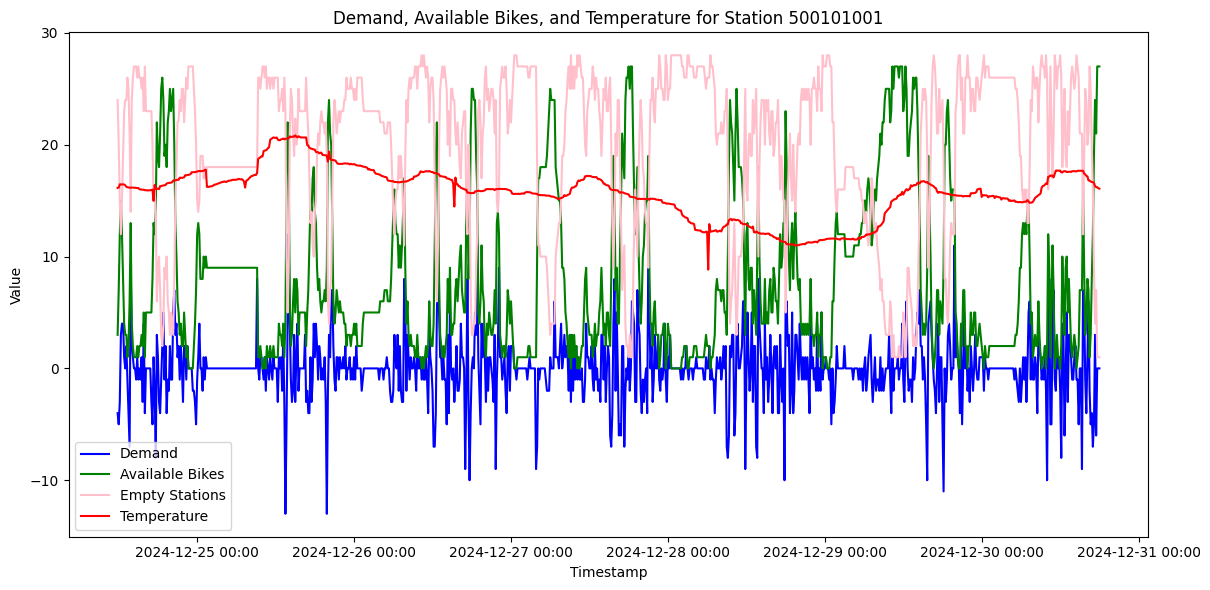

In [28]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plot demand, available bikes, and temperature for a specific station
station_id = "500101001"  # Replace with a valid station ID
df_station = df_merged[df_merged["youbike_station_id"] == station_id]

plt.figure(figsize=(12, 6))

# Plot demand
plt.plot(df_station["timestamp"], df_station["demand"], label="Demand", color="blue")

# Plot available rent bikes
plt.plot(df_station["timestamp"], df_station["available_rent_bikes"], label="Available Bikes", color="green")

# Plot available rent bikes
plt.plot(df_station["timestamp"], df_station["available_return_bikes"], label="Empty Stations", color="pink")

# Plot temperature
plt.plot(df_station["timestamp"], df_station["temperature"], label="Temperature", color="red")

# Customize plot
plt.legend()
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.title(f"Demand, Available Bikes, and Temperature for Station {station_id}")
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.tight_layout()
# Set date formatter for x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

# Show the plot
plt.show()


/tmp/ipykernel_1668579/3605497312.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_youbike_station["timestamp"] = pd.to_datetime(df_youbike_station["timestamp"])


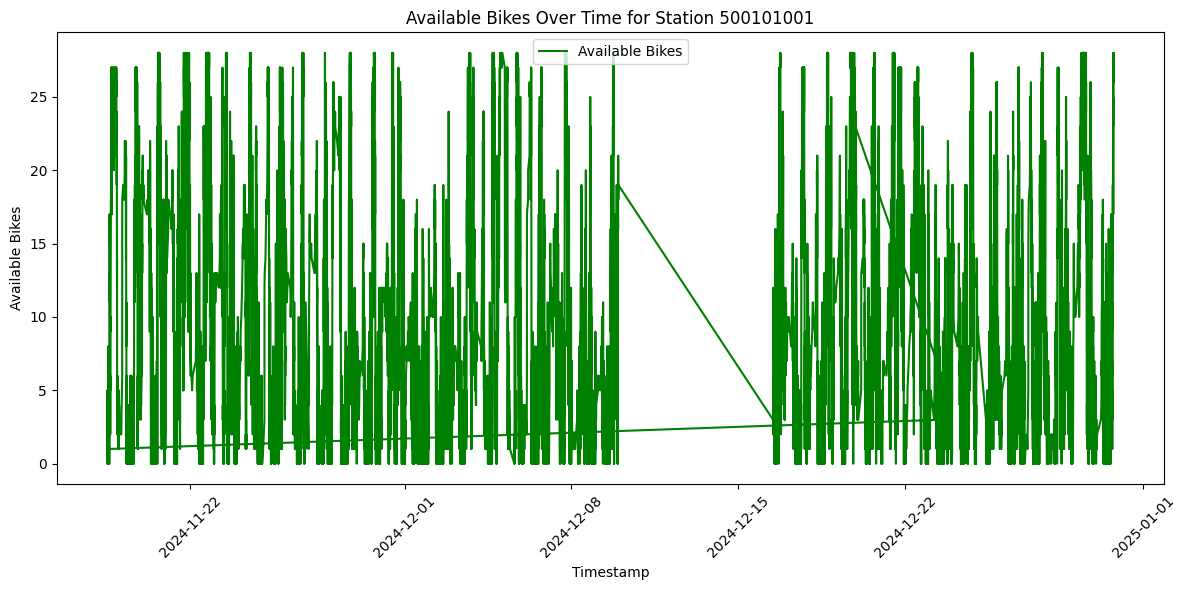

In [27]:
import matplotlib.pyplot as plt

# Filter the dataframe to the relevant station
station_id = "500101001"  # Example station ID
df_youbike_station = df_youbike[df_youbike["youbike_station_id"] == station_id]

# Ensure timestamps are in datetime format
df_youbike_station["timestamp"] = pd.to_datetime(df_youbike_station["timestamp"])

# Plot the available_rent_bikes over time
plt.figure(figsize=(12, 6))
plt.plot(
    df_youbike_station["timestamp"],
    df_youbike_station["available_rent_bikes"],
    label="Available Bikes",
    color="green",
)

# Customize the plot
plt.legend()
plt.xlabel("Timestamp")
plt.ylabel("Available Bikes")
plt.title(f"Available Bikes Over Time for Station {station_id}")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.tight_layout()

# Show the plot
plt.show()




In [30]:
df_merged.head()

,youbike_station_id,timestamp,available_rent_bikes,available_return_bikes,capacity,demand,temperature,wind_speed,humidity,pressure,rainfall
0,500101001,2024-12-24 11:50:00,3,24.0,27.0,-4,16.140000,2.266667,85.642857,1023.65,7.500000
1541,500101001,2024-12-24 12:00:00,7,20.0,27.0,-5,16.166667,2.266667,85.571429,1023.60,7.500000
2562,500101001,2024-12-24 12:10:00,12,15.0,27.0,-3,16.456250,2.250000,85.733333,1023.25,10.666667
4102,500101001,2024-12-24 12:20:00,15,12.0,27.0,3,16.462500,2.312500,85.600000,1023.10,7.625000
4798,500101001,2024-12-24 12:30:00,12,15.0,27.0,4,16.437500,2.312500,86.000000,1023.00,7.656250


In [25]:
df_youbike.head()

,youbike_station_id,timestamp,available_rent_bikes,available_return_bikes,capacity
0,500101001,2024-12-19 16:39:15,27,1,28
1,500101002,2024-12-19 16:40:16,14,7,21
2,500101003,2024-12-19 16:34:16,11,5,16
3,500101004,2024-12-19 16:38:15,10,1,11
4,500101005,2024-12-19 16:39:15,1,15,16


In [ ]:

# Optionally save the processed DataFrame
df_merged.to_csv("../dataprediction/processed_data_all_stations_weather.csv", index=False)
print("Processed data saved to 'processed_data.csv'")


OSError: Cannot save file into a non-existent directory: '../prediction'